## Hausarbeit Analyse technischer Daten
In dieser Hausarbeit soll ein Datensatz des deutschen Zentrums für Luft- und Raumfahrt analysiert werden.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats
import scipy.spatial
from tqdm.notebook import trange, tqdm

import report

### Daten analyse
Die Daten liegen als hdf5 Datei vor. Mitgegeben war eine Function, um die Daten als pandas DataFrame zu laden. Diese Funktion wurde leicht angepasst und in eine separate Datei ausgelagert.

In [2]:
import data

In [3]:
# we print the first and last summary of the data
for j in range(data.count_journeys())[::data.count_journeys()-1]:
    print('Journey ' + str(j) + ':')
    for _, sensor in enumerate(data.get_sensors()):
        df = data.read_data(j, sensor)
        print('  ' + sensor + ': ' + str(len(df)) + ' samples')

Journey 0:
  ADC1: 1441792 samples
  ADC2: 1441792 samples
  IMU: 7090 samples
Journey 17:
  ADC1: 782336 samples
  ADC2: 784384 samples
  IMU: 3891 samples


Die Daten sind in Fahrten der Lokomotive (`journey`) unterteilt. An einer Achse sind auf beiden Seiten Beschleunigungssensoren (ADC) angebracht, zusätzlich gibt es noch eine `Inertial measurement unit` (IMU). Laut beschreibung ist die Samplerate der Beschleunigungssensoren 20625 Hz.
Wir nutzen Pandas um uns kurz mit den Daten vertraut zu machen.

In [4]:
 data.read_data(jrn=0, source='ADC1').head(2)

,ch0,ch1,ch2,ch3,time,speed,trackID,vehicle_orientation,track_distance,direction,ch0_fft,distance,ch0_local_velocity,ch0_local_distance
0,-0.108808,0.046866,-0.023141,0.003736,2020-01-24 14:44:43.080495104,0.0,1664,1,10.399243,1.0,0.004654,0.0,0.000000,0.000000e+00
1,-0.064396,-0.038918,-0.014492,0.003574,2020-01-24 14:44:43.080543488,0.0,1664,1,10.399243,1.0,0.001735,0.0,0.000003,1.507527e-10


In [5]:
data.read_data(jrn=0, source='ADC1').describe()

,ch0,ch1,ch2,ch3,time,speed,trackID,vehicle_orientation,track_distance,direction,ch0_fft,distance,ch0_local_velocity,ch0_local_distance
count,1.441792e+06,1.441792e+06,1.441792e+06,1.441792e+06,1441792,1.441792e+06,1.441792e+06,1441792.0,1.441792e+06,1441792.0,1.441792e+06,1.441792e+06,1.441792e+06,1.441792e+06
mean,4.654444e-03,-2.457257e-02,8.508481e-04,3.141185e-01,2020-01-24 14:45:18.033004288,1.781442e+00,1.633843e+03,1.0,4.222362e+01,1.0,9.499861e-04,5.871757e+01,8.825766e-05,4.279186e-09
min,-1.757604e+02,-4.787234e+01,-9.150832e+01,-2.736127e-01,2020-01-24 14:44:43.080495104,0.000000e+00,1.612000e+03,1.0,5.830535e-03,1.0,2.001178e-07,0.000000e+00,0.000000e+00,0.000000e+00
25%,-7.387469e-01,-3.538879e-01,-4.042597e-01,3.757477e-03,2020-01-24 14:45:00.556749824,0.000000e+00,1.612000e+03,1.0,1.141431e+01,1.0,1.414089e-04,6.316861e+00,7.385074e-06,3.581402e-10
50%,-1.051847e-03,-1.963447e-02,9.349748e-04,5.167723e-03,2020-01-24 14:45:18.033004032,2.154165e+00,1.612000e+03,1.0,3.350300e+01,1.0,3.185289e-04,5.364896e+01,3.486705e-05,1.690291e-09
75%,6.983093e-01,3.044512e-01,4.143107e-01,6.179810e-03,2020-01-24 14:45:35.509258752,3.189557e+00,1.664000e+03,1.0,7.595866e+01,1.0,9.032902e-04,1.119319e+02,1.195183e-04,5.795232e-09
max,8.796044e+01,6.891758e+01,6.750553e+01,3.375329e+00,2020-01-24 14:45:52.985513216,3.639595e+00,1.664000e+03,1.0,8.853351e+01,1.0,7.451769e-02,1.245318e+02,8.503992e-03,4.114572e-07
std,3.356886e+00,1.117696e+00,1.573992e+00,9.268432e-01,NaN,1.404747e+00,2.566558e+01,0.0,3.070645e+01,0.0,2.629314e-03,4.870115e+01,1.367503e-04,6.630390e-09


In [6]:
data.read_data(jrn=0, source='IMU').head(2)

,timestamp,acc_x,acc_y,acc_z,ang_vel_x,ang_vel_y,ang_vel_z,gyro_x,gyro_y,gyro_z,orientation_x,orientation_y,orientation_z,orientation_w,roll,pitch,yaw
0,1.579877e+09,9.848949,-0.585371,-0.213709,0.017256,0.007055,-0.009730,0.017256,0.007055,-0.009730,0.208902,-0.677736,0.238087,0.663588,-97.431908,-87.37175,134.292694
1,1.579877e+09,9.731116,-0.449599,-0.127014,0.023184,0.004848,-0.007643,0.023184,0.004848,-0.007643,0.208904,-0.677742,0.238124,0.663567,-97.447212,-87.36824,134.311279


In [7]:
data.read_data(jrn=0, source='IMU').describe()

,timestamp,acc_x,acc_y,acc_z,ang_vel_x,ang_vel_y,ang_vel_z,gyro_x,gyro_y,gyro_z,orientation_x,orientation_y,orientation_z,orientation_w,roll,pitch,yaw
count,7.090000e+03,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000,7090.000000
mean,1.579877e+09,9.759216,-0.477673,-0.080515,0.017460,0.007317,-0.011276,0.017460,0.007317,-0.011276,0.207522,-0.679066,0.237275,0.662856,-101.317376,-87.224177,137.994170
std,2.046714e+01,0.226180,0.259296,0.171069,0.006223,0.006673,0.008872,0.006223,0.006673,0.008872,0.009055,0.003375,0.004701,0.003194,9.566583,0.963667,9.863579
min,1.579877e+09,7.967297,-2.519143,-1.168149,-0.015152,-0.036218,-0.086513,-0.015152,-0.036218,-0.086513,0.186107,-0.684458,0.226637,0.654527,-130.390549,-89.725983,95.062363
25%,1.579877e+09,9.653537,-0.586923,-0.165725,0.013545,0.003400,-0.015613,0.013545,0.003400,-0.015613,0.199913,-0.681734,0.234182,0.661325,-106.789787,-87.649757,132.662270
50%,1.579877e+09,9.759780,-0.463548,-0.078429,0.017744,0.007408,-0.011148,0.017744,0.007408,-0.011148,0.209770,-0.679681,0.237620,0.663119,-99.928017,-87.306213,136.775719
75%,1.579877e+09,9.853449,-0.352364,0.007887,0.021797,0.011480,-0.006655,0.021797,0.011480,-0.006655,0.213627,-0.677112,0.240450,0.664369,-96.380569,-86.850569,144.352062
max,1.579877e+09,13.736752,1.171136,1.148814,0.037655,0.044894,0.054015,0.037655,0.044894,0.054015,0.224563,-0.667430,0.250779,0.673559,-58.084270,-84.399406,167.429382


### Visualisierung der Daten

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

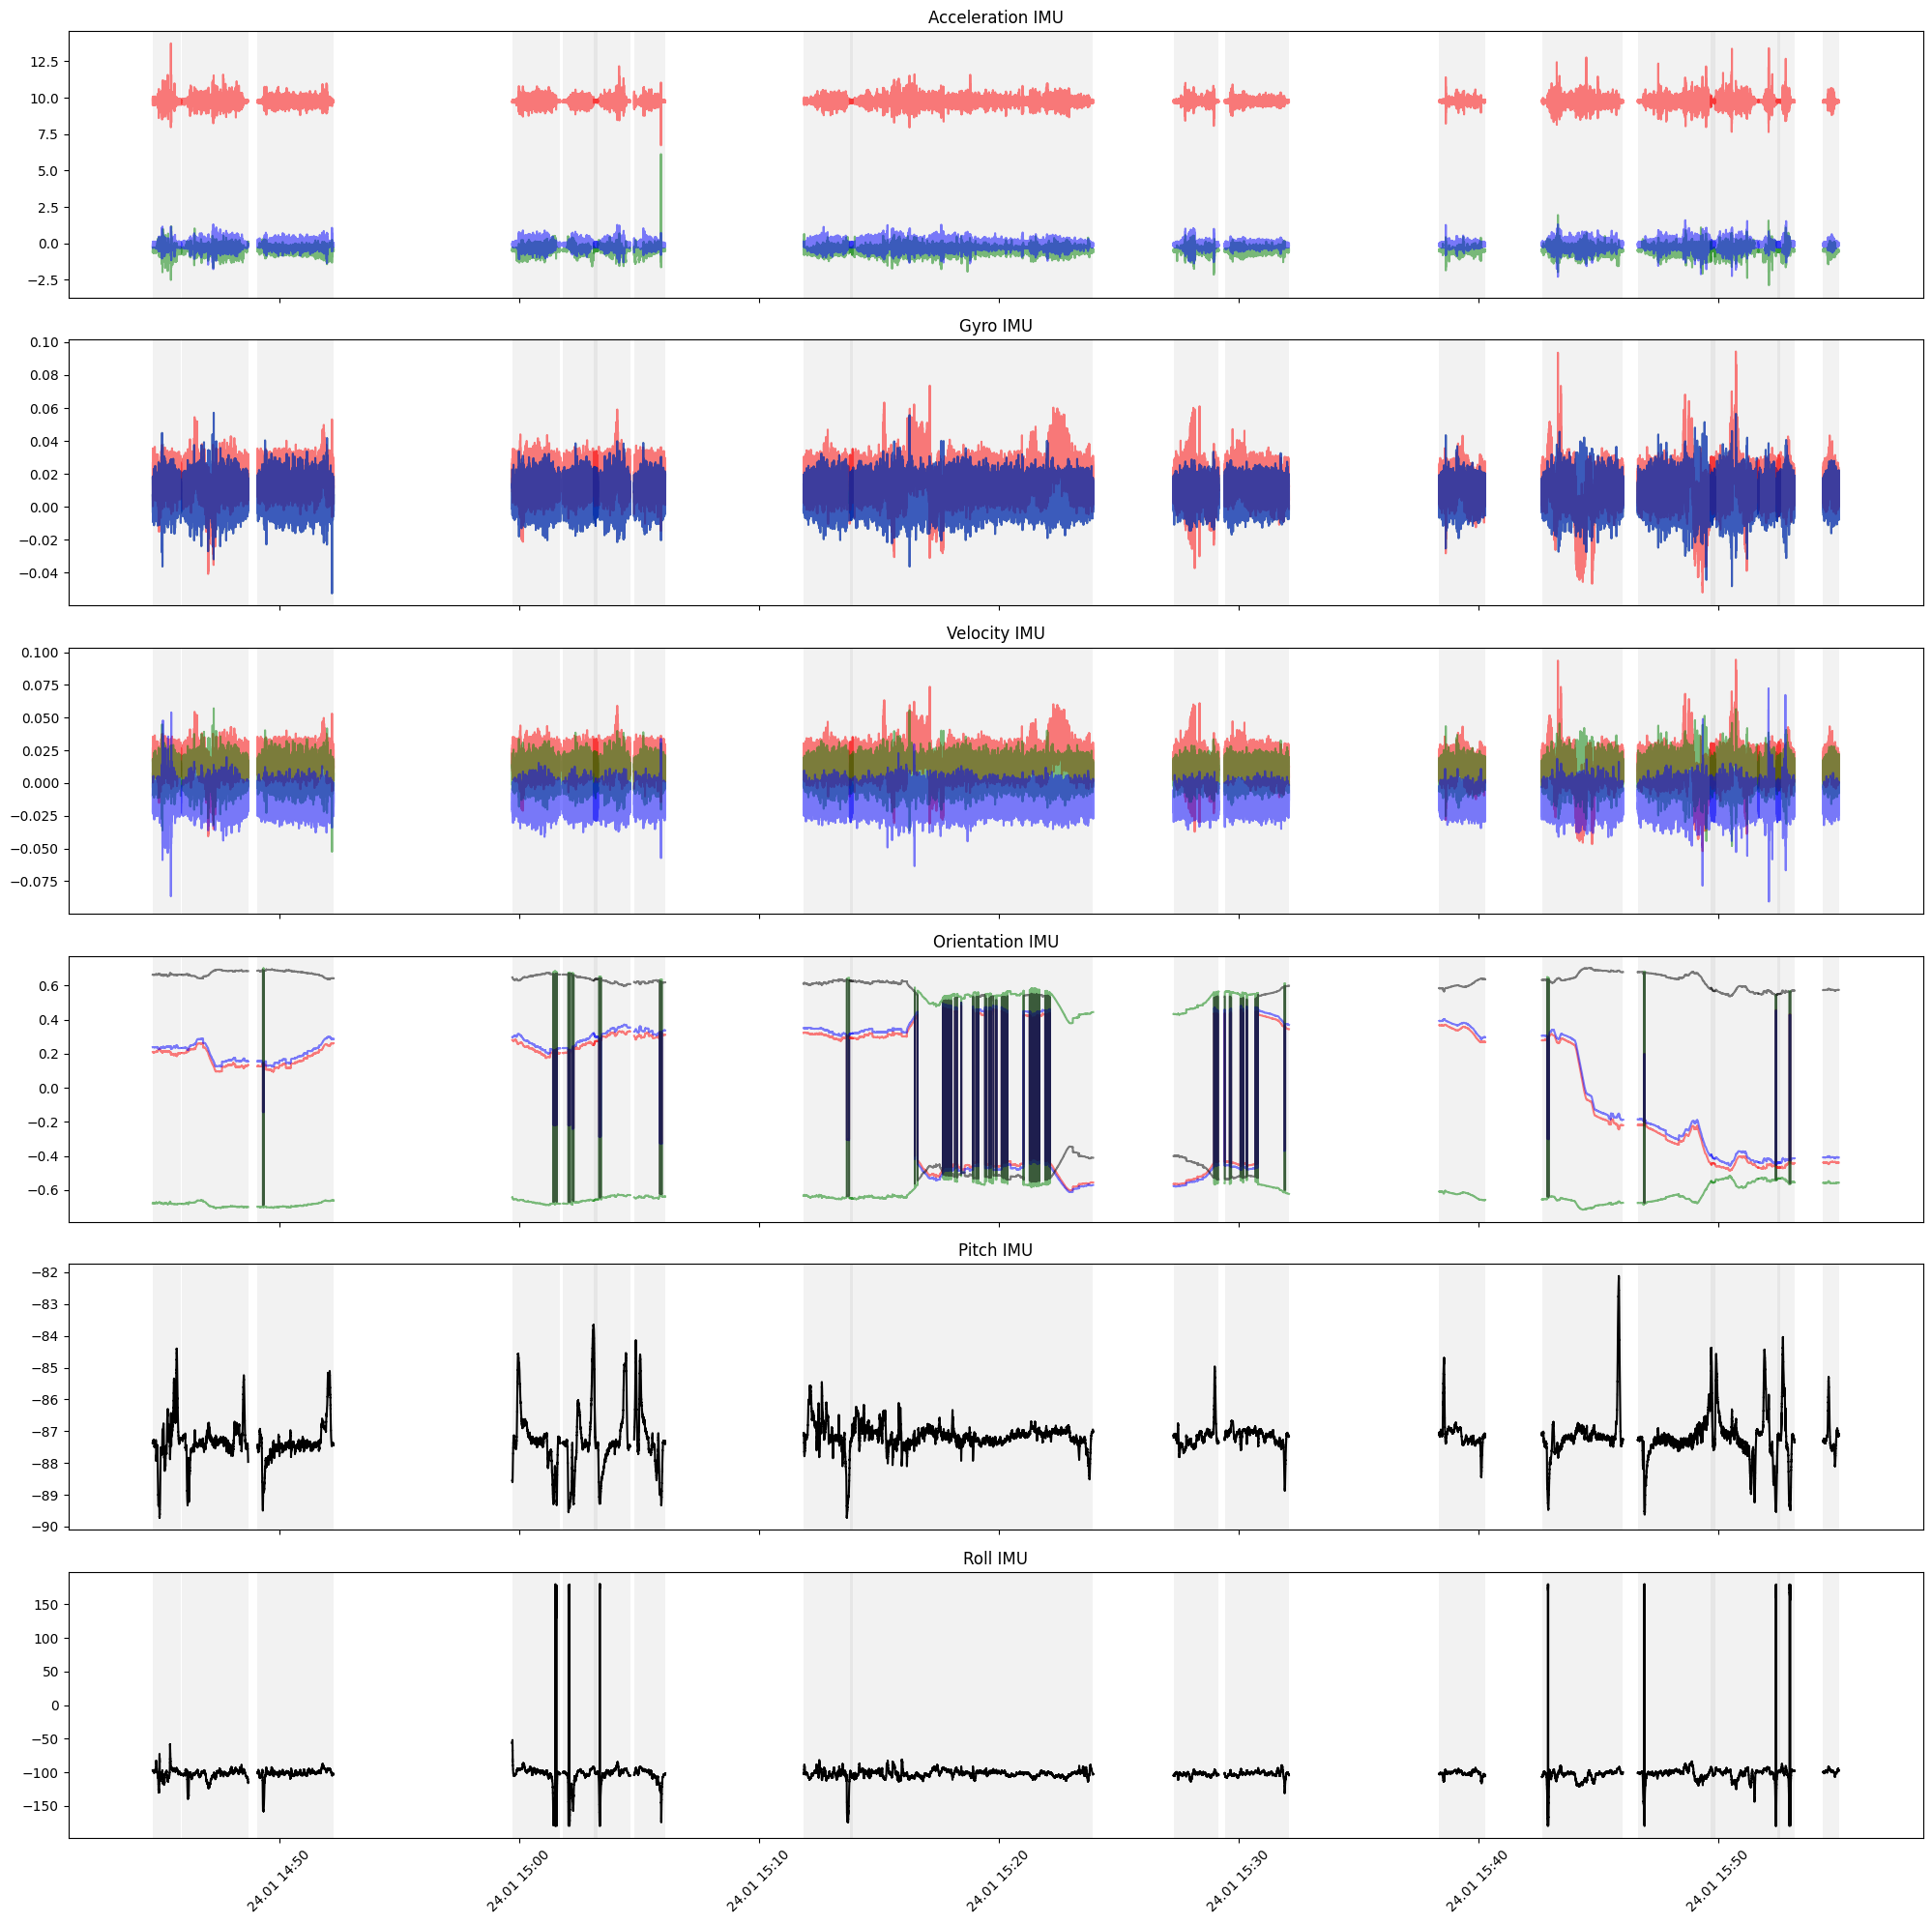

In [8]:
report.plot_imu_sensors()

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

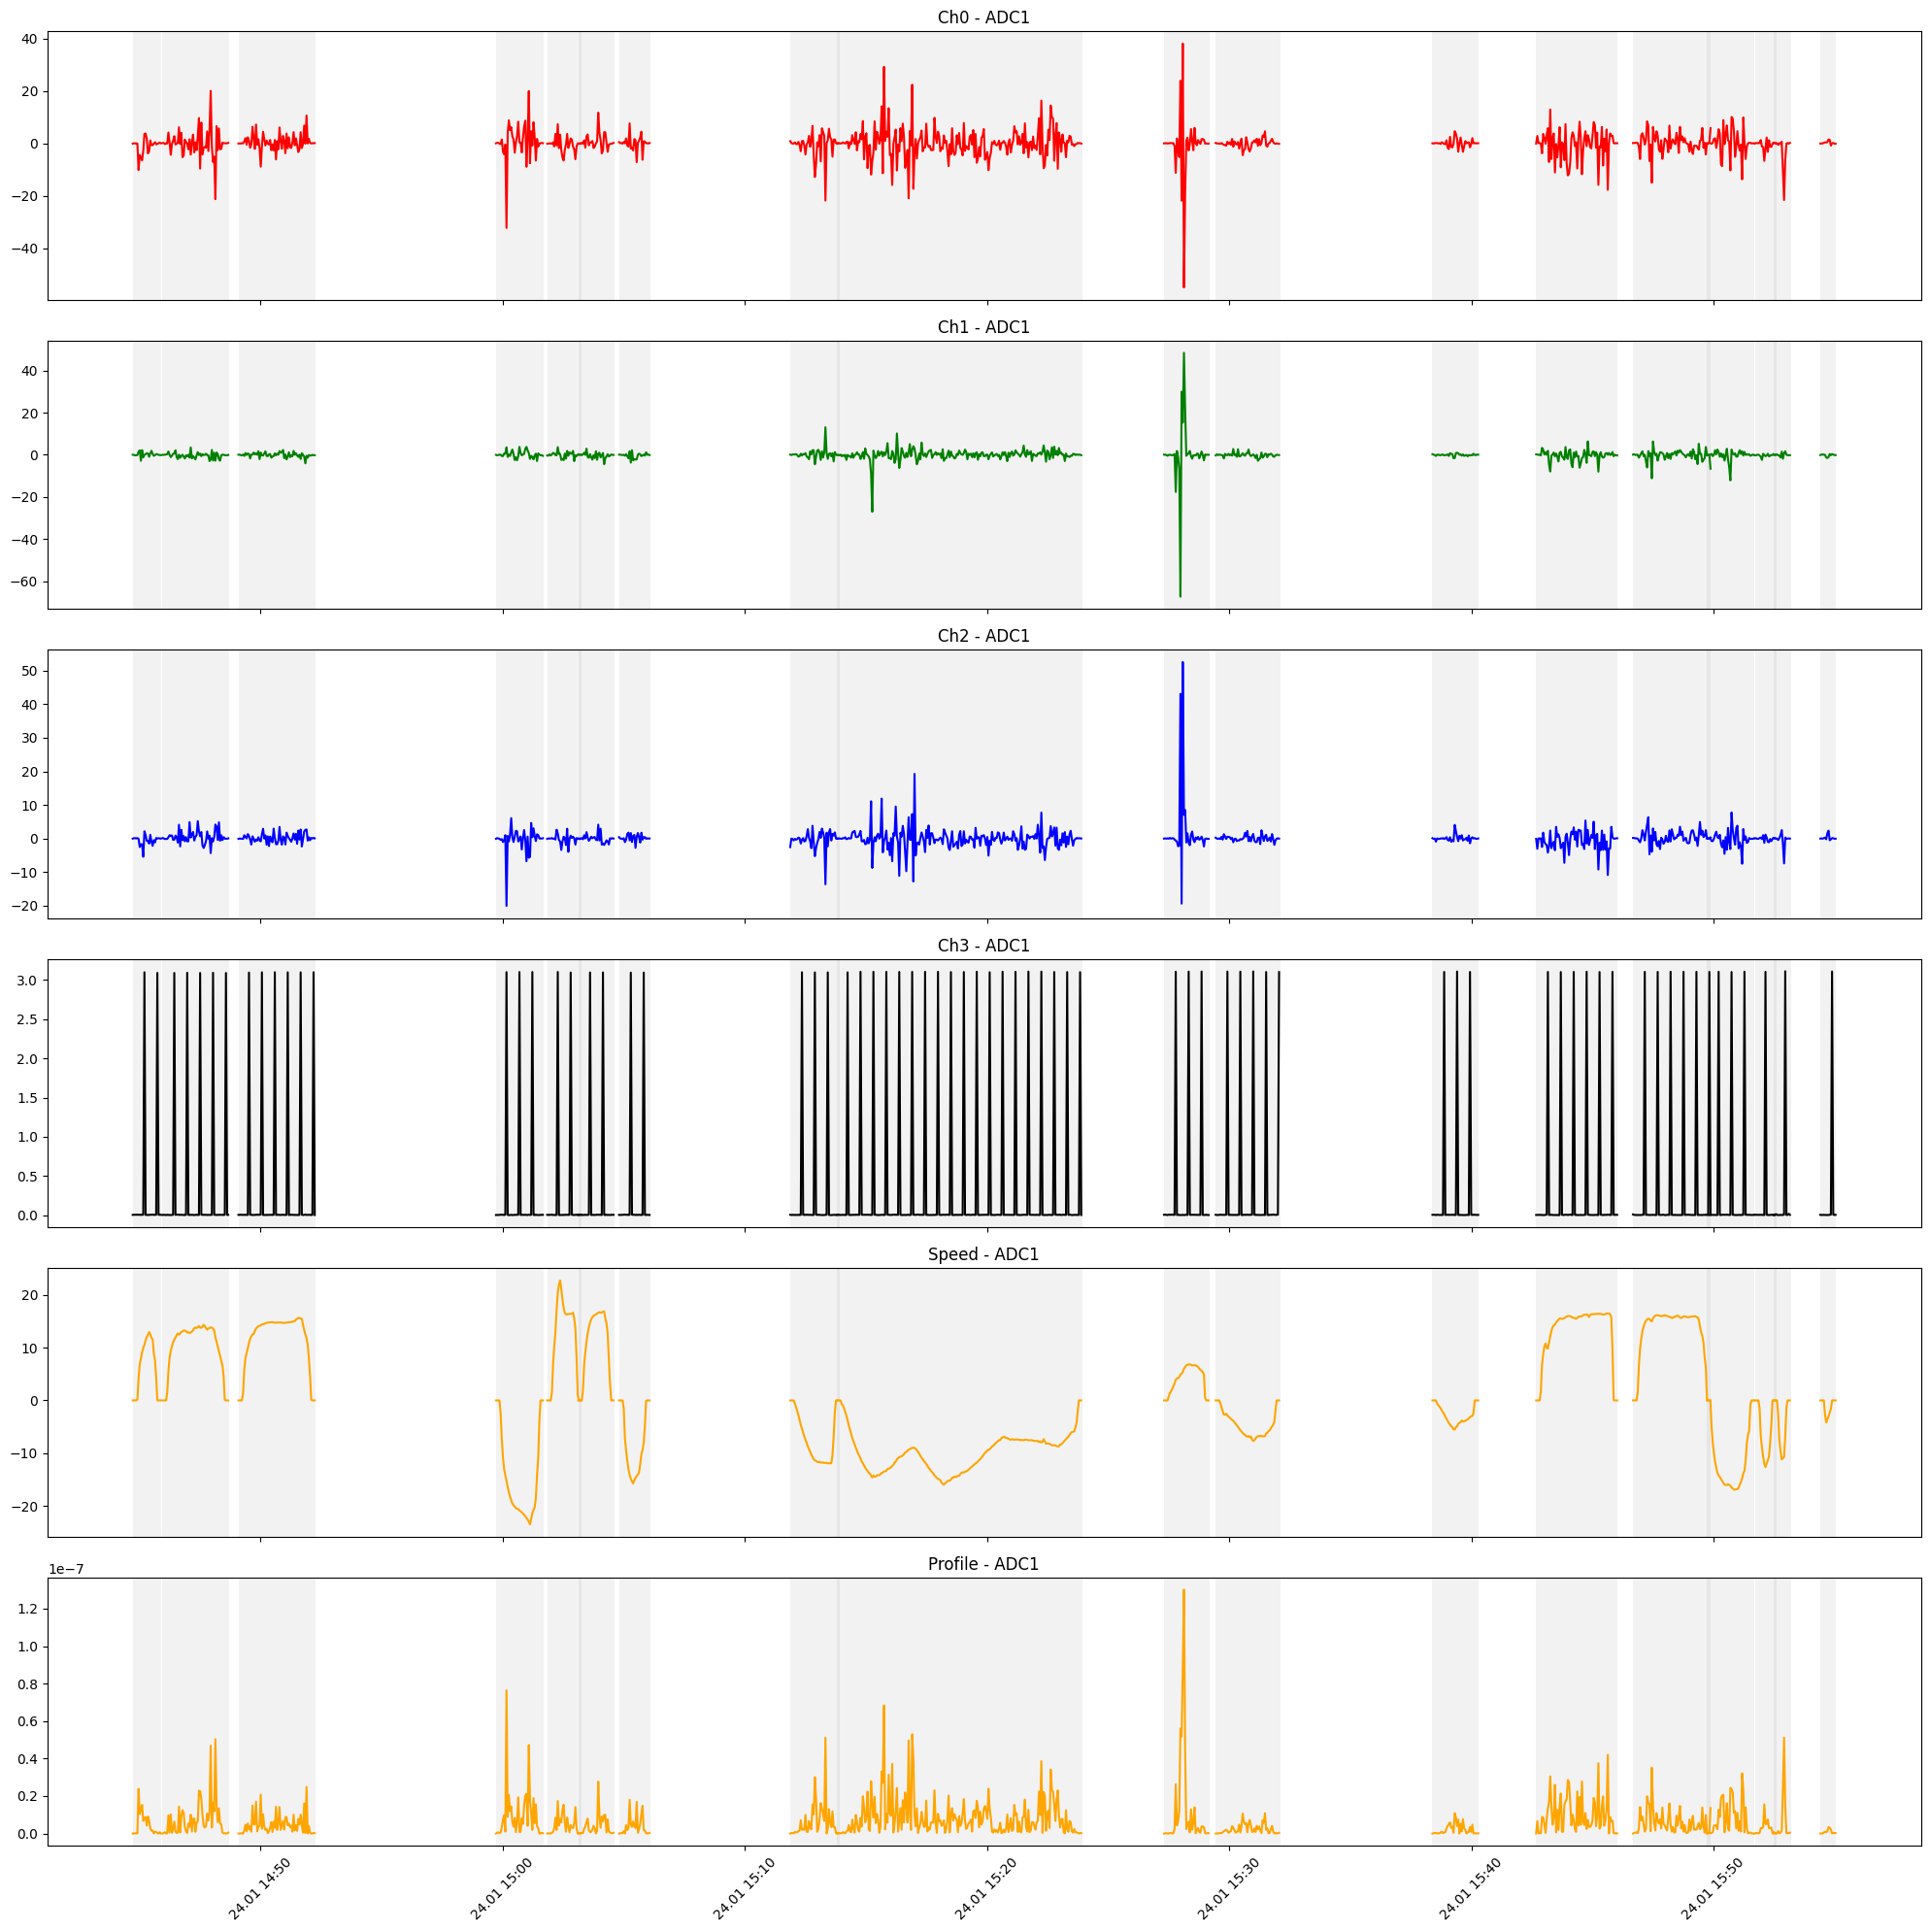

In [9]:
report.plot_sensors_adc(adc=1)

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

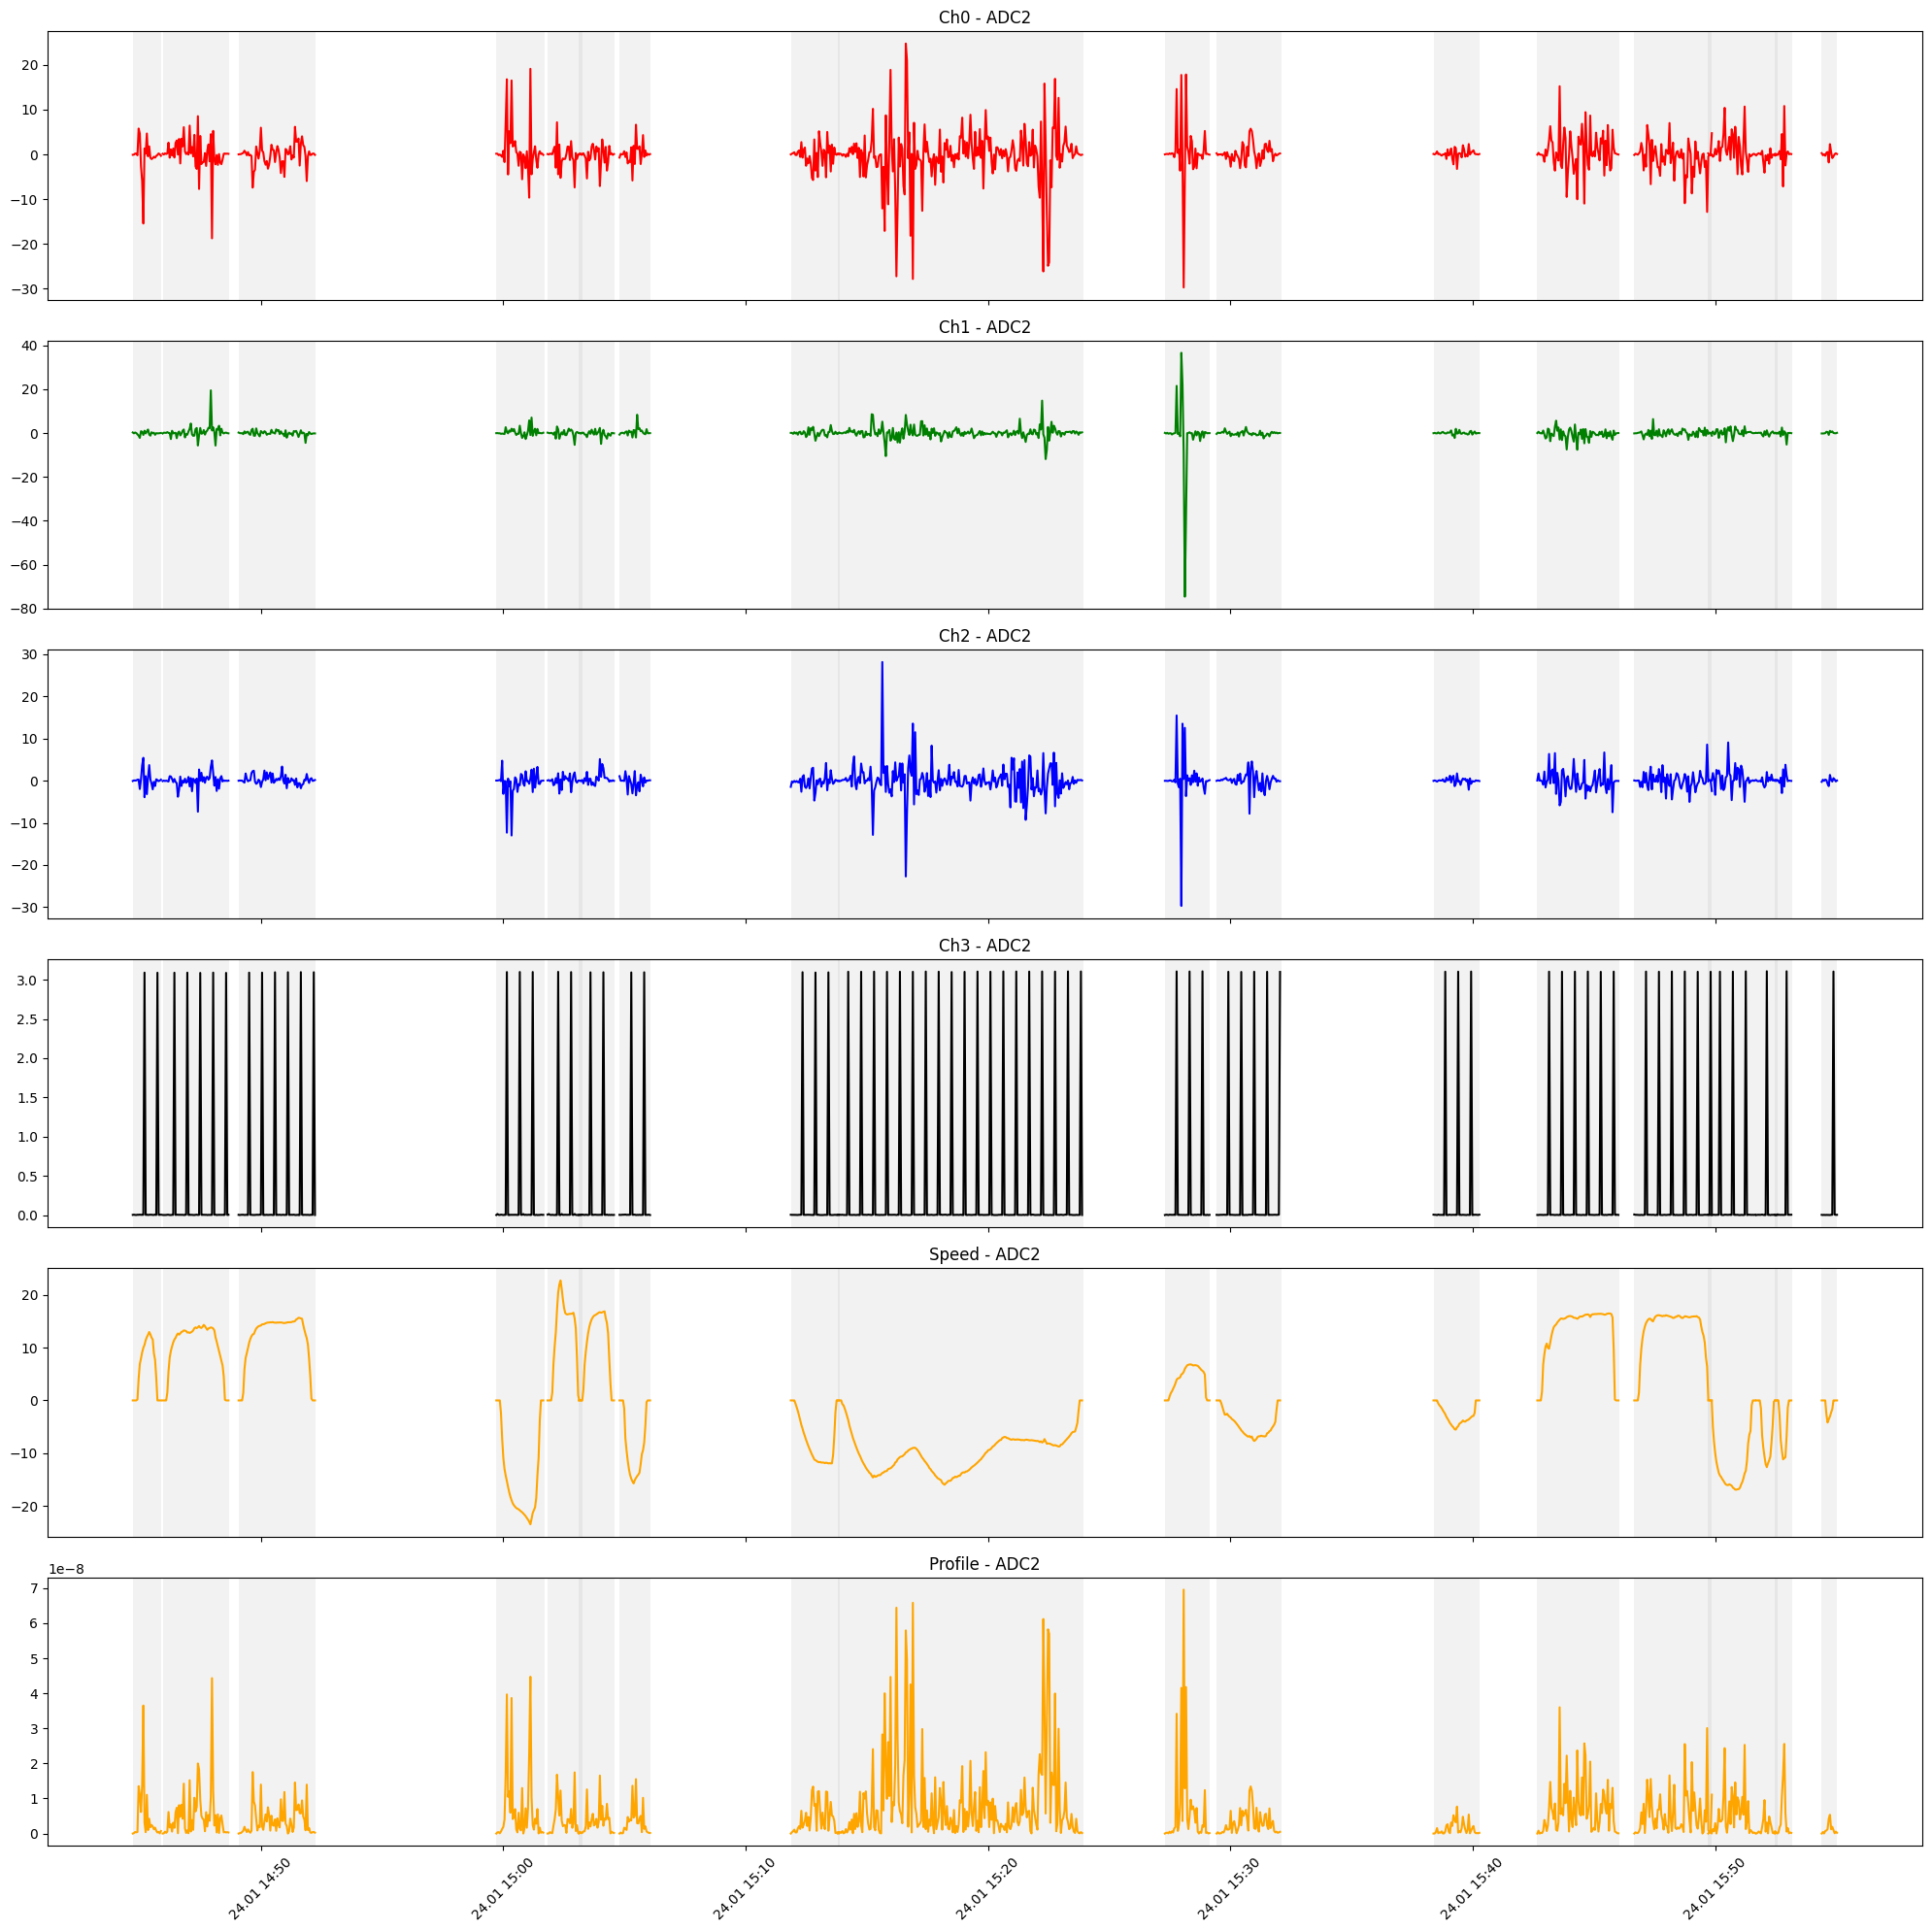

In [10]:
report.plot_sensors_adc(adc=2)

Mithilfe der longitudinal und lateralen Beschleunigung können wir die Fahrt der Lokomotive visualisieren indem wir die Beschleunigung doppelt integrieren.

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

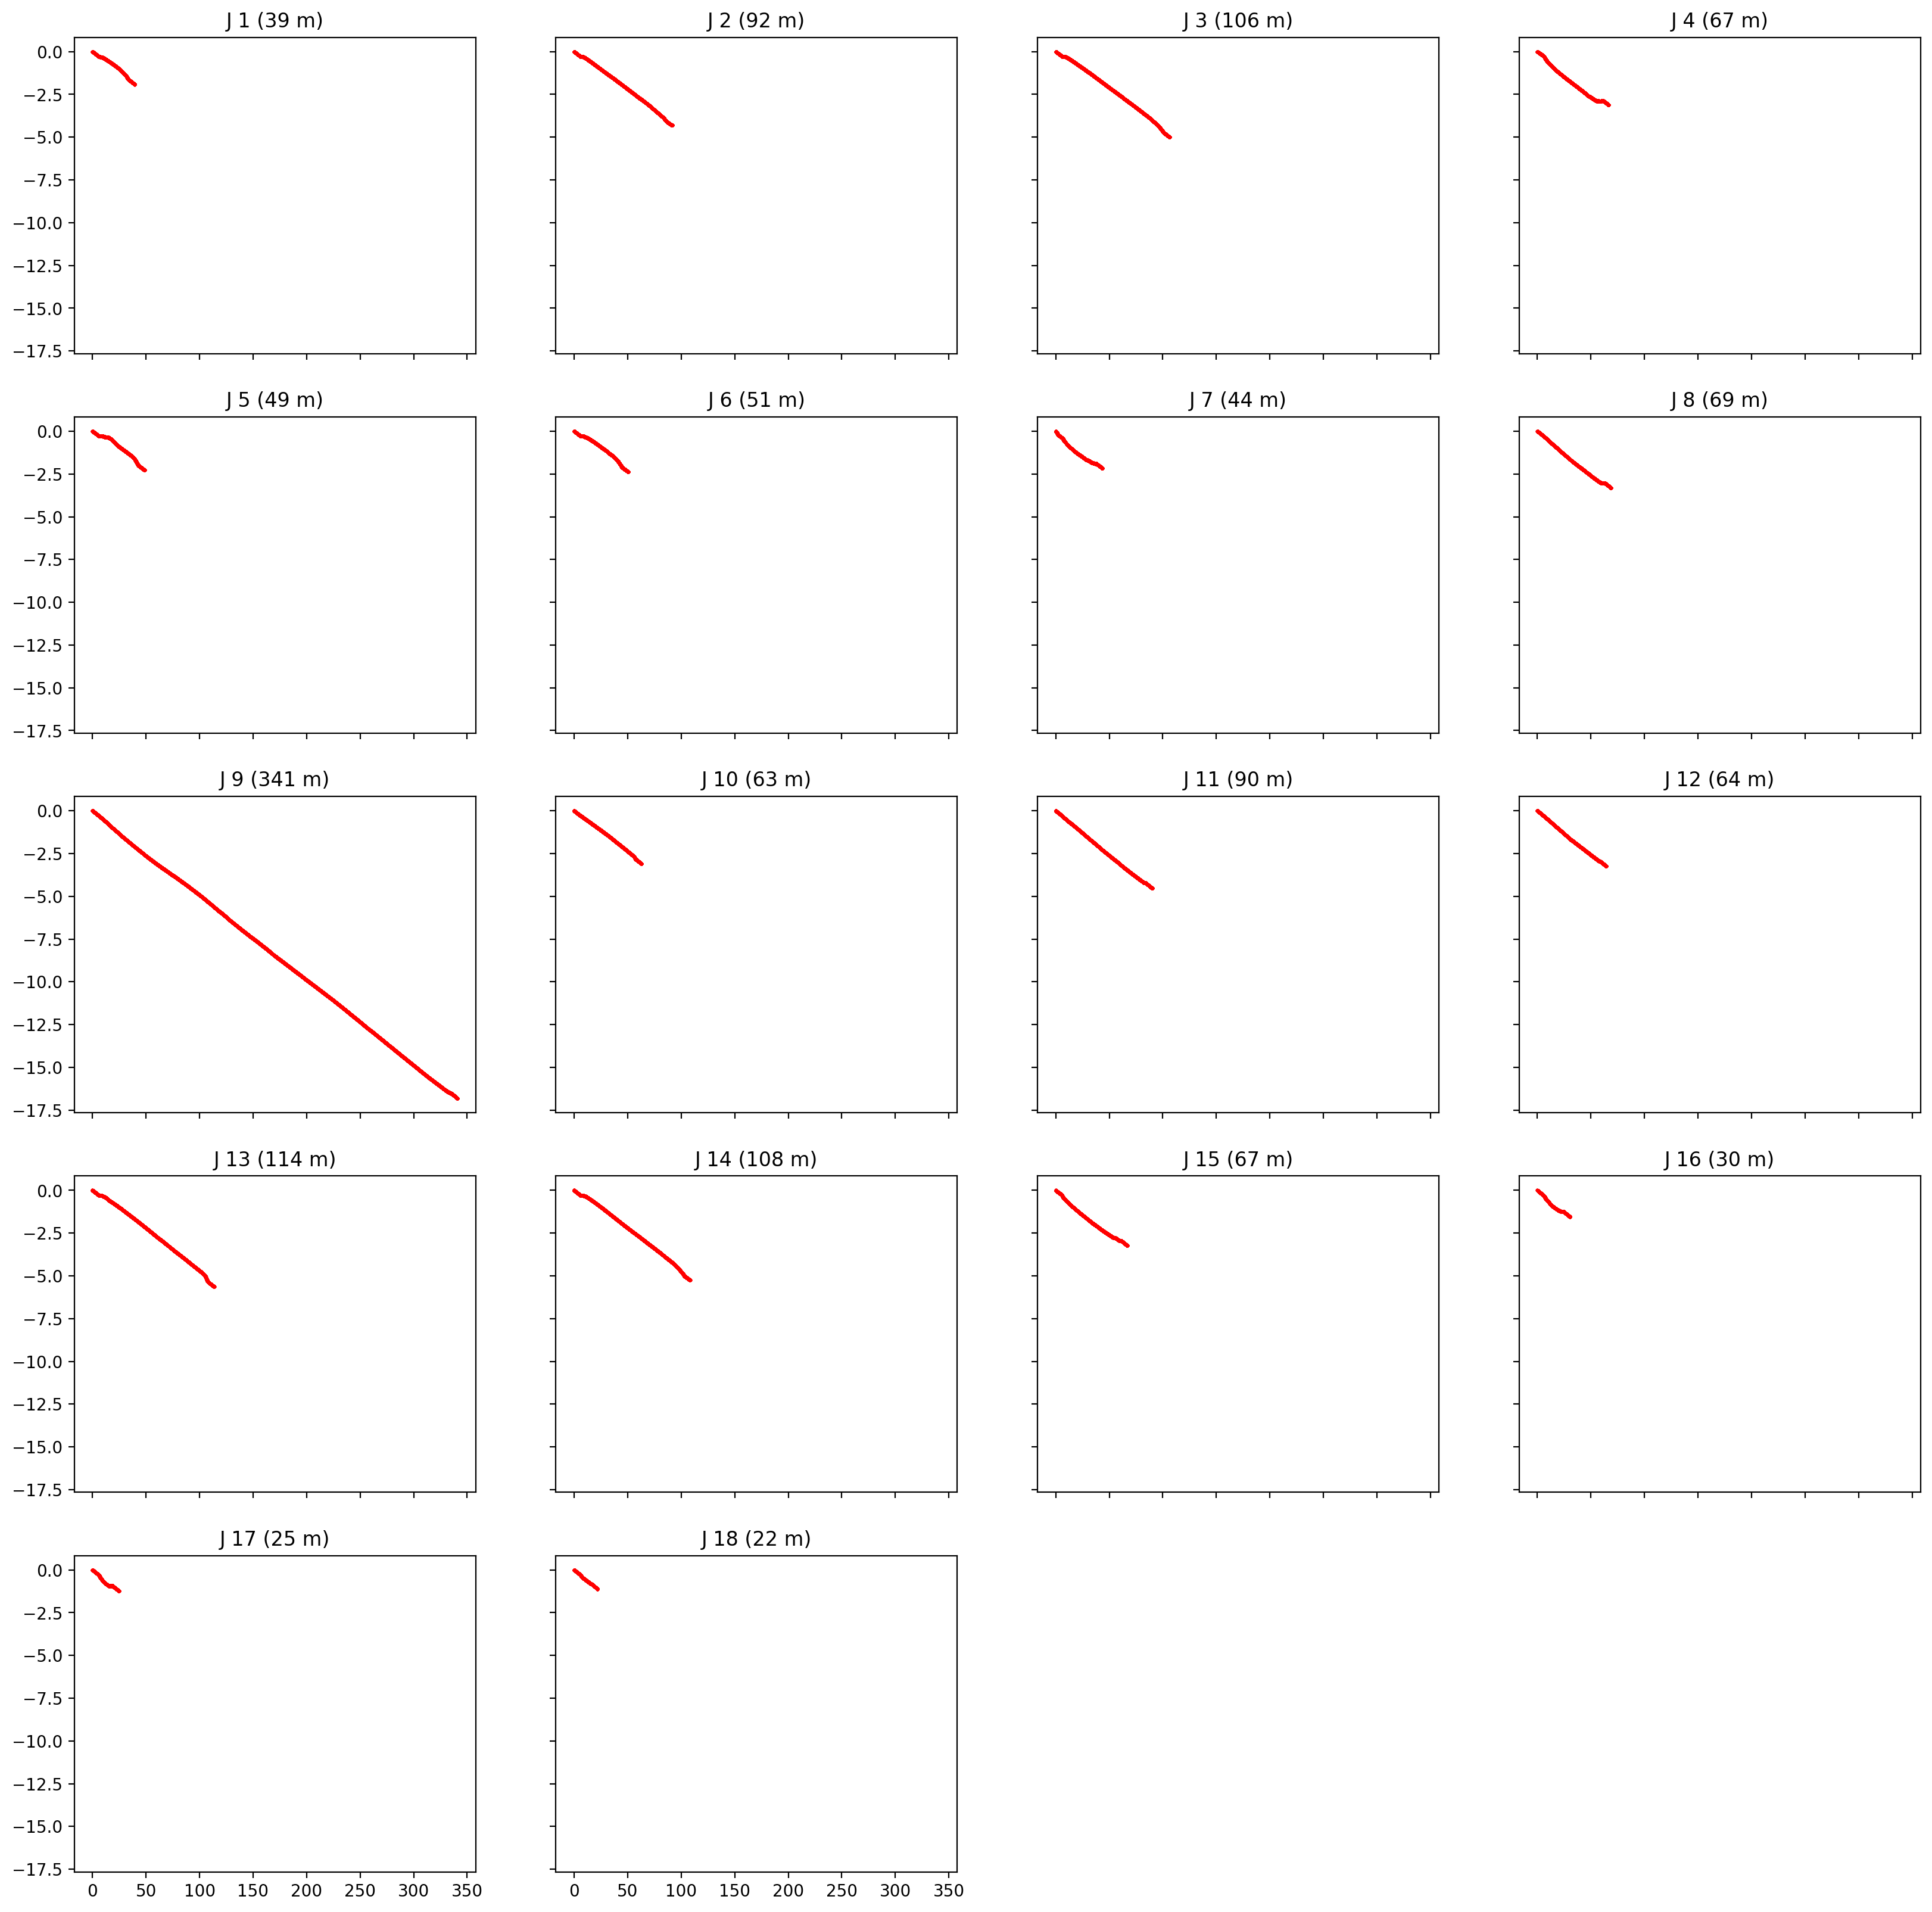

In [11]:
report.plot_positions()

#### Aufteilung in Bins
Dadurch, dass wir wissen, wie schnell die Lokomotive ist, können wir die gefahrene Strecke in gleich große Abschnitte einteilen. Diese Abschnitte nennen wir Bins. Wir können nun die Daten in diese Bins aufteilen und die Daten in jedem Bin einzeln analysieren.
Als erstes teilen wir die Daten in Bins zu 30cm Länge auf und errechnen die via fft die Frequenzen der vertikalen Beschleunigung ('ch0'-Signal) in jedem Bin.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

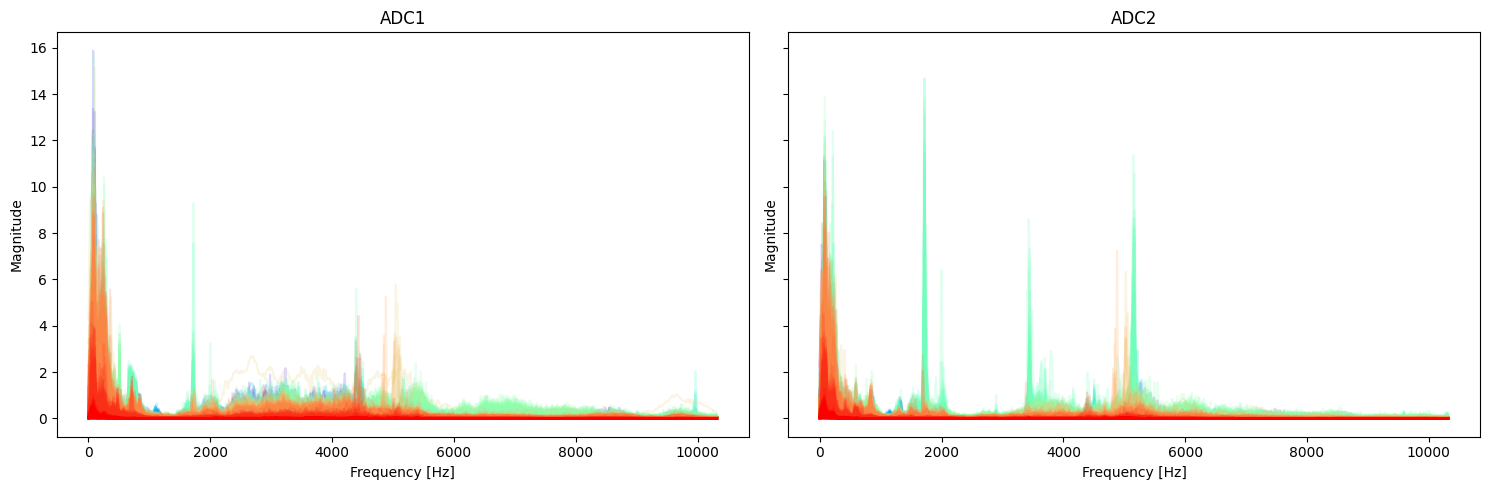

In [12]:
report.plot_frequencies_in_bins(sources=['ADC1', 'ADC2'],chunk_length=0.3)

### Feature Engineering
Der erste Ansatz ein ein Feature Engineering. Wir rechnen für jeden Bin einen Featurevektor aus, mit dem wir später die Klassifikation durchführen können. Um die Dimension des Featurevektors zu reduzieren errechnen wir eine Principle Component Analysis (PCA) und nutzen nur die ersten 3 Hauptkomponenten.
Als Features nutzen wir
- das artithmetische Mittel der vertikalen Beschleunigung
- den root mean square (RMS) der vertikalen Beschleunigung
- das 25,50 und 75 Quantil der vertikalen Beschleunigung
- den maximalen absoluten Wert der vertikalen Beschleunigung
- die Starnardabweichung der vertikalen Beschleunigung
- den Peak to Peak Wert der vertikalen Beschleunigung
- die Kurtosis der vertikalen Beschleunigung
- die Skewness der vertikalen Beschleunigung
- und die Entropie der vertikalen Beschleunigung


Diese Liste wurde aus diesem [Paper](https://arxiv.org/pdf/2101.11539.pdf) inspiriert

Journey:   0%|          | 0/18 [00:00<?, ?it/s]

Journey 1 explained variances: [0.5008994  0.16814738 0.12753538], total: 79.66%
Journey 2 explained variances: [0.52197526 0.1457443  0.11115922], total: 77.89%
Journey 3 explained variances: [0.47836727 0.1724099  0.13812448], total: 78.89%
Journey 4 explained variances: [0.49894808 0.16306561 0.12408072], total: 78.61%
Journey 5 explained variances: [0.50045956 0.18010669 0.13620778], total: 81.68%
Journey 6 explained variances: [0.50911715 0.15904759 0.13179066], total: 80.00%
Journey 7 explained variances: [0.50910409 0.17658814 0.13751043], total: 82.32%
Journey 8 explained variances: [0.52555779 0.1535388  0.11102876], total: 79.01%
Journey 9 explained variances: [0.52554755 0.14066887 0.11119359], total: 77.74%
Journey 10 explained variances: [0.5330688  0.18022343 0.10568312], total: 81.90%
Journey 11 explained variances: [0.52705712 0.15813623 0.14138526], total: 82.66%
Journey 12 explained variances: [0.53756568 0.123395   0.11745071], total: 77.84%
Journey 13 explained vari

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

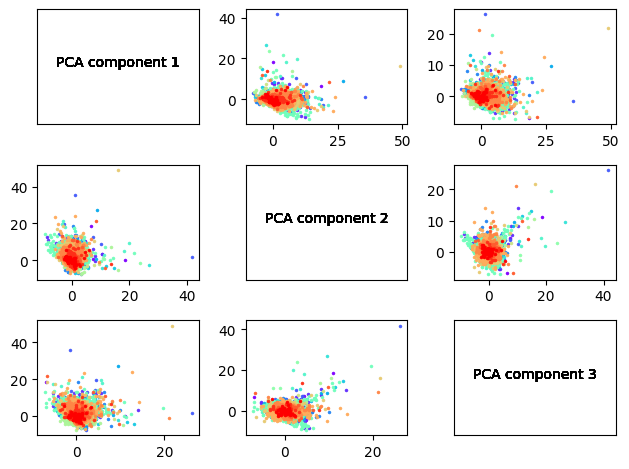

In [13]:
report.conduct_pca_on_featues(source='ADC1', count_components=3, feature_lambda=lambda x: x)

Da hier keine verwertbaren Cluster zu sehen waren, wurde das Signal nochmal mit einer fft transformiert und die Features auf dem Spektrum berechnet.

Journey:   0%|          | 0/18 [00:00<?, ?it/s]

Journey 1 explained variances: [0.67645623 0.20800498 0.07403552], total: 95.85%
Journey 2 explained variances: [0.72337338 0.16970604 0.07857519], total: 97.17%
Journey 3 explained variances: [0.61784658 0.24830375 0.09704834], total: 96.32%
Journey 4 explained variances: [0.61718099 0.22893606 0.11611618], total: 96.22%
Journey 5 explained variances: [0.61083781 0.20689065 0.13453043], total: 95.23%
Journey 6 explained variances: [0.64706699 0.21314897 0.1056438 ], total: 96.59%
Journey 7 explained variances: [0.59714124 0.23322864 0.12431374], total: 95.47%
Journey 8 explained variances: [0.65959049 0.20297198 0.09767446], total: 96.02%
Journey 9 explained variances: [0.67524485 0.19845302 0.08272705], total: 95.64%
Journey 10 explained variances: [0.71513104 0.20808253 0.05640122], total: 97.96%
Journey 11 explained variances: [0.54176931 0.25325849 0.15552579], total: 95.06%
Journey 12 explained variances: [0.64870211 0.21352877 0.09770177], total: 95.99%
Journey 13 explained vari

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

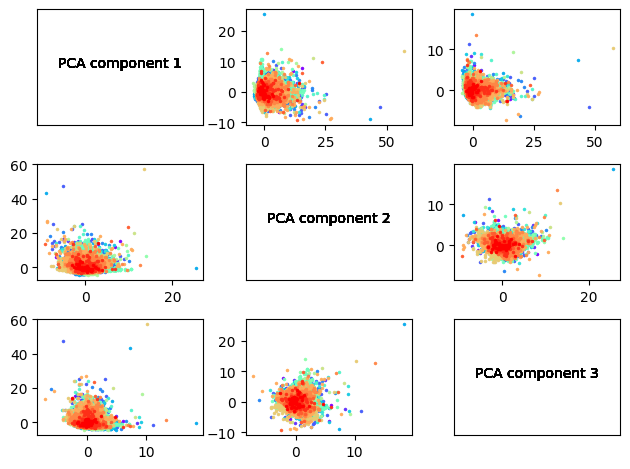

In [14]:
report.conduct_pca_on_featues(source='ADC1', count_components=3, feature_lambda=lambda x: np.abs(np.fft.fft(x)))

Auch hier konnte keine sichtbaren Cluster gefunden werden. Deshalb wurde dieser Weg nicht weiter verfolgt und stattdessen andere Ansätze gesucht.


### Distanz Ansatz
Dieser Ansatz basiert auf der Idee, dass bei intakten Schienen und gerader Fahrt die vertikale Beschleunigung auf beiden Achsen änlich sein muss. Wenn ein Rad über eine Schadstelle fährt, dann sollte die vertikale Beschleunigung auf der Achse mit der Schadstelle anders sein als auf der anderen Achse. Wir können also die Distanz zwischen den beiden vertikalen Beschleunigungen als Feature nutzen. Eine Achse dient als Bin-Referenz, für die andere Achsen suchen wir die Daten, die in der Zeit des Bins aufgenommen wurden.
Zwei Distanzmaße wurden ausprobiert:
- die Korrelation der beiden Signale
- das dynamische Time Warping (DTW)

#### Korrelationansatz

  0%|          | 0/414 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

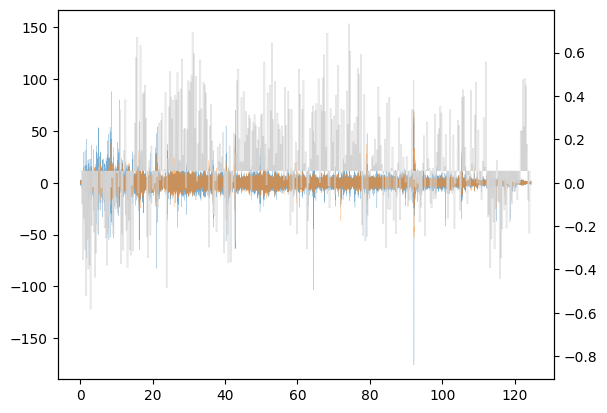

In [15]:
adc1_df = data.read_as_chuncked(0, 'ADC1')
adc2_df = data.read_as_chuncked(0, 'ADC2')

adc1_df["Correlation"] = np.nan
adc2_df["Correlation"] = np.nan

for j in trange(int(np.max(adc1_df["Bin"]))):

    # get the time of the bin
    time_start = np.min( adc1_df[adc1_df["Bin"] == j]["time"])
    time_end = np.max( adc1_df[adc1_df["Bin"] == j]["time"])

    # get the data of the bin by the time
    bin_adc1 = adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"]
    bin_adc2 = adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"]

    length = np.min([len(bin_adc1), len(bin_adc2)])
    corr, _ = scipy.stats.pearsonr(bin_adc1[:length], bin_adc2[:length])

    adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "Correlation"] = corr
    adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "Correlation"] = corr

fig, axs = plt.subplots()

axs.plot(adc1_df["distance"], adc1_df["ch0"], linewidth=0.2, alpha=0.6)
axs.plot(adc2_df["distance"], adc2_df["ch0"], linewidth=0.2, alpha=0.6)


axs2 = axs.twinx()
validcorrelations = adc2_df["Correlation"] != np.nan
axs2.plot(adc2_df[validcorrelations]["distance"], adc2_df[validcorrelations]["Correlation"], c="#D3D3D3",  linewidth=0.4)

# helper function to align both y axis to the same offset
report.align_yaxis(axs, axs2)
plt

Die Hoffnung war, hier Spikes zu sehen, wo die Correlation der beiden Signale stark abfällt. Leider war dies nicht der Fall. Deshalb wurde ein anderer Ansatz gesucht und das DTW ausprobiert. Das DTW ist ein Distanzmaß, dass die Distanz zwischen zwei Zeitreihen berechnet. Es ist invariant gegenüber Verschiebung und Skalierung der Zeitreihen. Wir verwenden die Implementierung aus der [tslearn](https://tslearn.readthedocs.io/en/stable/) Bibliothek.

Als Beispiel können wir einmal die Distanz zwischen zwei Bins berechnen.


DTW distance: 131.18596130164397


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

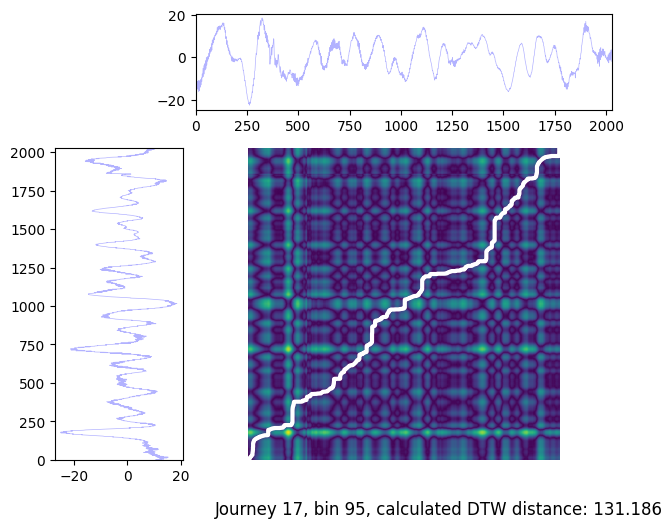

In [16]:
import tslearn.metrics

# shameless inspired from https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html

random_journey = np.random.randint(0, data.count_journeys())
adc1_df = data.read_as_chuncked(random_journey, 'ADC1')
adc2_df = data.read_as_chuncked(random_journey, 'ADC2')

random_bin = np.random.randint(0, int(np.max(adc1_df["Bin"])))

# get the time of the bin
time_start = np.min(adc1_df[adc1_df["Bin"] == random_bin]["time"])
time_end = np.max(adc1_df[adc1_df["Bin"] ==random_bin]["time"])

# get the data of the bin by the time
s1 = np.array(adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"])
s2 = np.array(adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"])

# we cut the signals to the same length
s1 = s1[:np.min([len(s1), len(s2)])]
s2 = s2[:np.min([len(s1), len(s2)])]


sz = s1.shape[0]
path, sim = tslearn.metrics.dtw_path(s1, s2)
print ("DTW distance:", sim)

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.08

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = scipy.spatial.distance.cdist(s1.reshape(-1,1), s2.reshape(-1,1))

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)

ax_s_x.plot(np.arange(sz), s2, "b-", alpha=0.3,  linewidth=0.5)


ax_s_x.set_xlim((0, sz - 1))
ax_s_x.set_label("ADC 1")


ax_s_y.plot(- s1, np.arange(sz), "b-", alpha=0.3,  linewidth=0.5)
ax_s_y.set_label("ADC 2")
ax_s_y.set_ylim((0, sz - 1))

plt.title(f"Journey {random_journey + 1}, bin {random_bin + 1}, calculated DTW distance: {sim:.3f}", y=-0.2, x=3)

plt

Diesen Ansatz können wir nun auf alle Bins anwenden und die Distanzen als Anomalie-Threshold nutzen.

Selected journey: 3


  0%|          | 0/2082 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

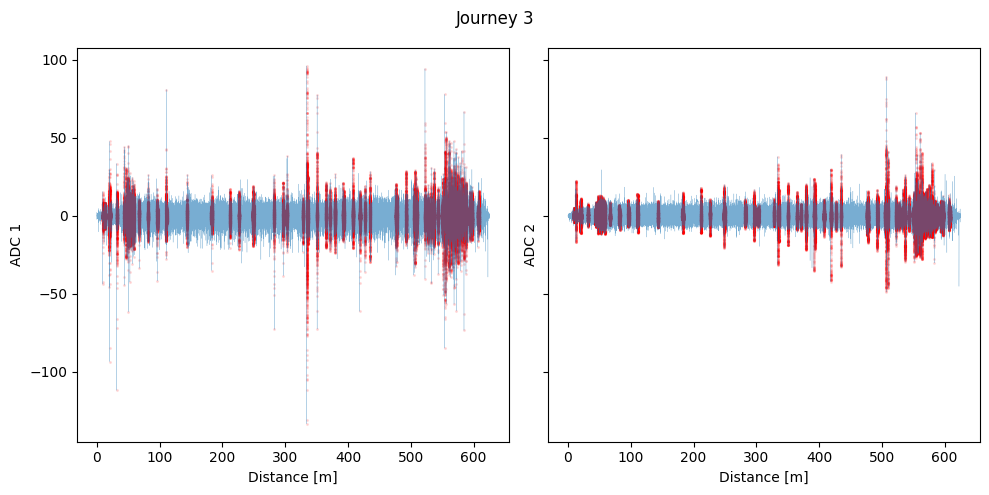

In [17]:
random_journey = np.random.randint(0, data.count_journeys())
print(f"Selected journey: {random_journey + 1}")

# we read the data
adc1_df = data.read_as_chuncked(random_journey, 'ADC1')
adc2_df = data.read_as_chuncked(random_journey, 'ADC2')

# we add a column for the distance
adc1_df["DTWDistance"] = np.nan
adc2_df["DTWDistance"] = np.nan

for j in trange(int(np.max(adc1_df["Bin"]))):
    try:
        time_start = np.min(adc1_df[adc1_df["Bin"] == j]["time"])
        time_end = np.max(adc1_df[adc1_df["Bin"] == j]["time"])

        bin_adc1 = adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"]
        bin_adc2 = adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"]

        length = np.min([len(bin_adc1), len(bin_adc2)])

        dwt_distance = tslearn.metrics.dtw(bin_adc1[:length], bin_adc2[:length])

        adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "DTWDistance"] = dwt_distance
        adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "DTWDistance"] = dwt_distance

    except:
        # this sometimes fails when the bin is too large (dtw needs to allocate too much memory).
        # Especially at the start of the journey. We ignore those.
        pass


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5) )

 # Define 95 % percentile of max as threshold.
adc1_df_anomalies = adc1_df["DTWDistance"] >= np.nanpercentile(adc1_df["DTWDistance"], 95)
adc2_df_anomalies = adc2_df["DTWDistance"] >= np.nanpercentile(adc2_df["DTWDistance"], 95)


axs[0].scatter(adc1_df[adc1_df_anomalies]["distance"], adc1_df[adc1_df_anomalies]["ch0"], color="red", alpha=0.1, s=1.5)
axs[0].plot(adc1_df["distance"], adc1_df["ch0"], linewidth=0.2, alpha=0.6)
axs[0].set_ylabel("ADC 1")
axs[0].set_xlabel("Distance [m]")

axs[1].scatter(adc2_df[adc2_df_anomalies]["distance"], adc2_df[adc2_df_anomalies]["ch0"], color="red", alpha=0.1, s=1.5)
axs[1].plot(adc2_df["distance"], adc2_df["ch0"], linewidth=0.2, alpha=0.6)
axs[1].set_ylabel("ADC 2")
axs[1].set_xlabel("Distance [m]")

fig.suptitle(f"Journey {random_journey + 1}")
plt.tight_layout()

plt

Was wir sehen ist, dass hier durchaus Cluster gefunden werden. Leider haben wir keine Möglichkeit, diese Cluster als Schadstelle zu identifizieren.

### Timeseries Anomaly Detection mit LSTM Autoencoders
Ein weiterer Ansatz ist es, die Daten als Zeitreihen zu betrachten und mit einem LSTM Autoencoder Anomalien zu finden. Wir bauen ein Neuronales Netz das seinen eigenen Input lernt. Wenn bei der evaluierung der reconstruction loss über einen Schwellwert liegt, dann liegt eine Anomalie vor.

Der Code liegt in der funktion `train_lstm_autoencoder`. Das Training der Netze dauert auf meinem Rechner mit allen Journeys bis zu 2 Tage. Teilweise wurden die Netze auch nicht fertig trainiert. Die modelle sind mit ihren trainierten weights im subfolder `results` gespeichert. Es wurden drei unterschiedliche Modelle unterschliedlicher Größe trainiert.
- Ein recht großes Model mit 198914 Parametern. Als input und output featues wurden die `ch0`- und `speed`-Werte der ADCs verwendet
- Ein kleineres Model mit 3074 Parametern. Als input und output featues wurden die `ch0`- und `speed`-Werte der ADCs verwendet
- Ein noch kleineres Model mit 1138 Parametern. Als input und output featues wurden statt der Beschleunigungsdate die fft Koeffizienten der Beschleunigungsdaten verwendet, da diese in der Analyse oben sichbare Spikes gezeigt hatten.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 128)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 time_distributed (TimeDist  (None, 1, 2)              258       
 ributed)                                               

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

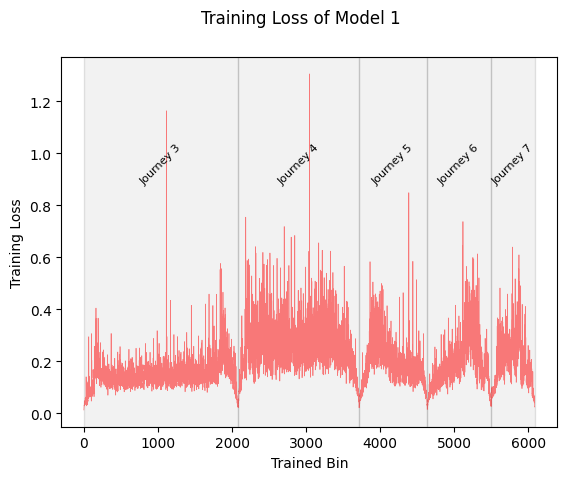

In [18]:
import tensorflow as tf

# load model
model = tf.keras.models.load_model(f"./results/model_1/model.keras")
model.summary()


loss_df = pd.read_pickle(f"./results/model_1/loss.pkl")
fig, axs = plt.subplots()
axs.plot(loss_df["Loss"],'r-', label="Loss", linewidth=0.5, alpha=0.5)

for j in loss_df['Journey'].unique():
    rect_x = loss_df[loss_df['Journey'] == j].index[0]
    rect_y = loss_df[loss_df['Journey'] == j].index[-1]
    axs.axvspan(rect_x, rect_y, facecolor='gray', edgecolor="black", alpha=0.1,  linewidth=1)

    # write centered text
    text_x = loss_df[loss_df['Journey'] == j].index[0] + (loss_df[loss_df['Journey'] == j].index[-1] - loss_df[loss_df['Journey'] == j].index[0])/2
    text_y = np.max(loss_df["Loss"]) * 0.8
    axs.text(text_x, text_y, f"Journey {j + 1}", verticalalignment='top', horizontalalignment='center', fontsize=8, rotation=45)



axs.set_xlabel("Trained Bin")
axs.set_ylabel("Training Loss")

fig.suptitle("Training Loss of Model 1")

plt

Wir können nun den reconstruction loss für alle Bins berechnen und die Verteilung der Losses plotten. Wir definieren für unser model das 99 % Percentil der Losses als Schwellwert für eine Anomalie.

Managed to load scaler from disk.
109356/109356 [==============================] - 152s 1ms/step
(3499361,)
63685/63685 [==============================] - 114s 2ms/step
(2037914,)
42361/42361 [==============================] - 88s 2ms/step
(1355522,)
44796/44796 [==============================] - 90s 2ms/step
(1433443,)
36298/36298 [==============================] - 73s 2ms/step
(1161512,)


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

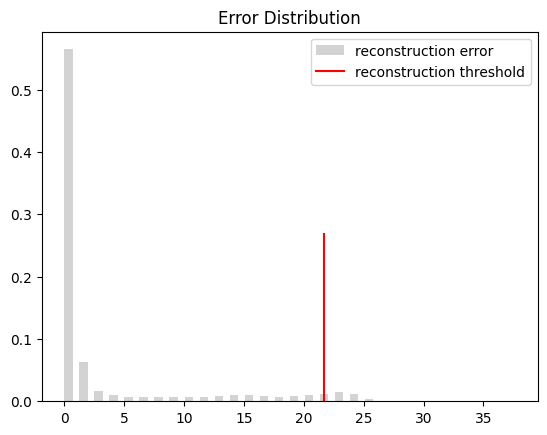

In [19]:
features=['speed', 'ch0']

# calculate standard scaler for our features
scaler = data.create_scaler_for_features('ADC1', features)

errors = []

for j in loss_df['Journey'].unique():
    df = data.read_as_chuncked(j, 'ADC1')

    # transform the features by the same scaler we used for training
    df_transformed = scaler.transform(df[features]).reshape(-1, 1, 2)

    # we predict the reconstruction
    prediction = model.predict(df_transformed)

    # we calculate reconstruction error (mean absolute error)
    mean_absolute_error = np.mean(np.abs(prediction - df_transformed), axis=1)[:, 1]

    print(mean_absolute_error.shape)
    errors.append(mean_absolute_error)


# we flatten the list of errors
training_errors = np.concatenate(errors)

# we define the threshold as the 95 percentile of the training error
max_train_error = np.percentile(training_errors, 95)

# we plot the distribution of the errors
plt.title('Error Distribution')
# plt.yscale("log")
hist = plt.hist(training_errors, bins=30, density=True, label="reconstruction error", color="#D3D3D3", width=0.7)

# we limit the hight of the threshold line, so it does not look too aggressive
y_ver_max = hist[0][0] * 0.8
plt.axvline(x=max_train_error, ymax=y_ver_max, color='r', label="reconstruction threshold")
plt.legend()
plt

Wir schauen nun in den ersten 3 Journeys nach Anomalien. Die ersten beiden Journeys wurden nicht trainiert, die dritte Journey wurde trainiert.

122496/122496 [==============================] - 299s 2ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

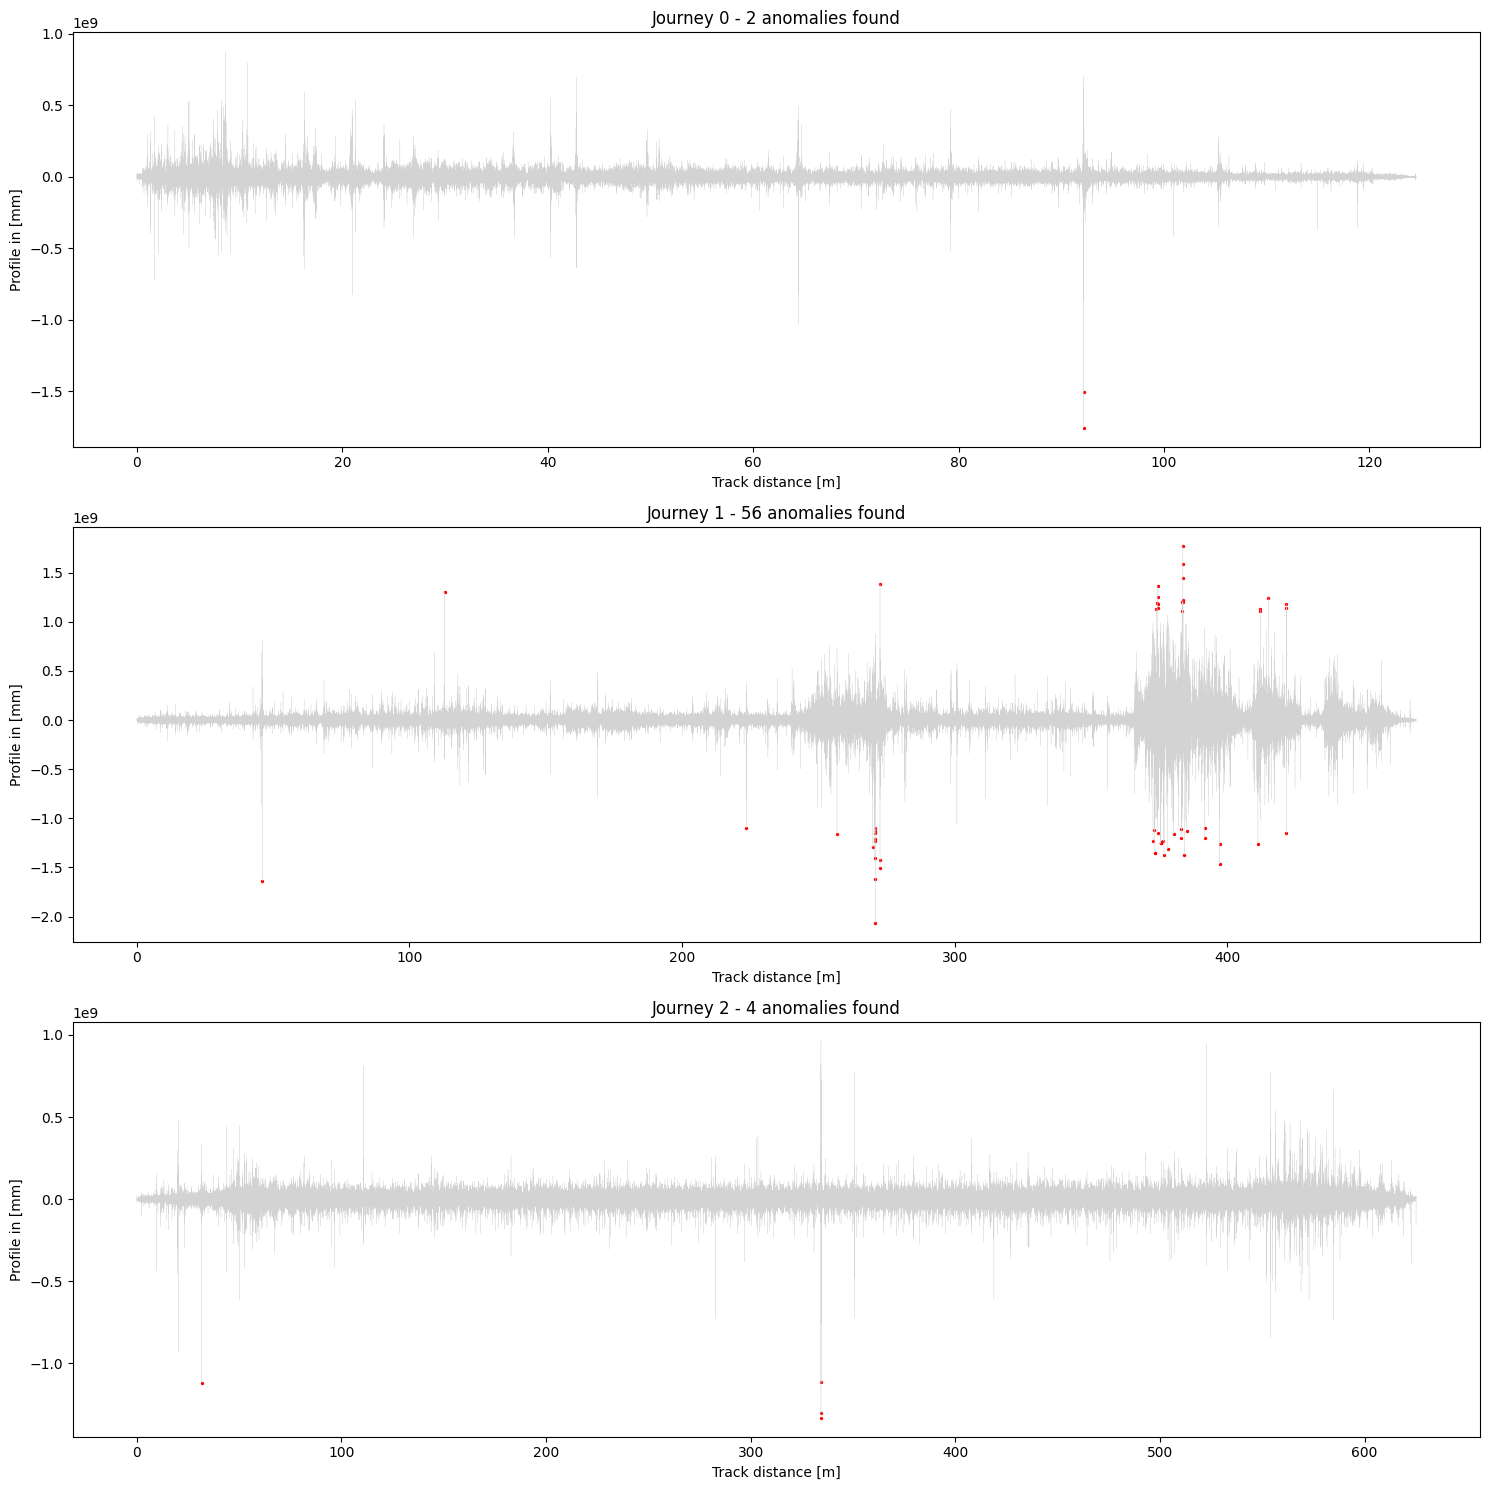

In [20]:
count_test_journeys = 3
fig, axs = plt.subplots(count_test_journeys, figsize=(15, 15))
for j in range(count_test_journeys):
    df_journey = data.read_data(j, 'ADC1')
    df_journey["speed"] = np.abs(df_journey["speed"])

    # scale intput data to all our recorded data
    features_transformed = scaler.transform(df_journey[features])
    # lets evaluate the model for this journey
    journey_data = features_transformed.reshape(-1, 1, 2)
    # this might take some time..
    test_predict = model.predict(journey_data)

    test_error = np.mean(np.abs(test_predict - journey_data), axis=1)

    # again we only look for the errors of the profile reconstruction
    anomalies = test_error[:, 1] >= max_train_error

    to_mm = 10 ** 7
    axs[j].set_title(f"Journey {j} - {np.sum(anomalies)} anomalies found")
    axs[j].scatter(df_journey[anomalies]["distance"], df_journey[anomalies]["ch0"] * to_mm, color="red", s=2)
    axs[j].plot(df_journey["distance"], df_journey["ch0"] * to_mm, color="#D3D3D3", linewidth=0.2)


for ax in axs.flat:
    ax.set(xlabel='Track distance [m]', ylabel='Profile in [mm]')

fig.tight_layout()
plt

Für das zweite Model gehen wir genau so vor. Dieses Model wurde mit allen Journeys trainiert.

Model summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             1216      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                                 
 time_distributed (TimeDist  (None, 1, 2)              34        
 ributed)                                   

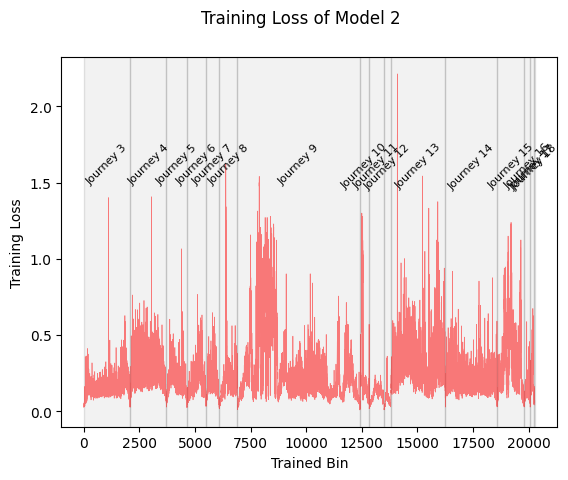

Managed to load scaler from disk.
Calculate loss of training to determine the threshold for anomalies.
109356/109356 [==============================] - 157s 1ms/step
(3499361,)
63685/63685 [==============================] - 91s 1ms/step
(2037914,)
42361/42361 [==============================] - 61s 1ms/step
(1355522,)
44796/44796 [==============================] - 67s 1ms/step
(1433443,)
36298/36298 [==============================] - 52s 1ms/step
(1161512,)
65703/65703 [==============================] - 96s 1ms/step
(2102467,)
378635/378635 [==============================] - 540s 1ms/step
(12116303,)
59505/59505 [==============================] - 91s 2ms/step
(1904160,)
89476/89476 [==============================] - 138s 2ms/step
(2863217,)
60255/60255 [==============================] - 86s 1ms/step
(1928159,)
116830/116830 [==============================] - 165s 1ms/step
(3738547,)
 10987/111066 [=>............................] - ETA: 2:25

In [ ]:
report.evaluate_lstm_autoencoder(
    model_version=2,
    features = ['speed', 'ch0'],
    percentil_threshold=95)

Für das dritte Model gehen wir ebenso so vor, bis dass wir die fft Koeffizienten der Beschleunigungsdaten als Features verwenden.

In [ ]:
report.evaluate_lstm_autoencoder(
    model_version=3,
    features = ['speed', 'ch0_fft'],
    percentil_threshold=95)

### Zusammenfassung und Ausblick
